# Customer Churn Prediction with XGBoost Classifier

---



Setting the random seed for reproducibility




In [1]:
seed = 42

Importing the necessary libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

Reading the CSV file

In [3]:
churn = "/content/Customer Churn Data/Churn_Modelling.csv"
c_churn = pd.read_csv(churn)
c_churn

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


## Data Pre-processing

We observe that the columns "RowNumber", "CustomerId" and "Surname" will have no impact on wether a customer will leave the bank; so we drop these columns.

In [4]:
c_churn.drop(["RowNumber","CustomerId","Surname"], axis = 1, inplace = True)

In [5]:
c_churn.shape

(10000, 11)

In [6]:
c_churn

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


Observe that "Gender" and "Geography" are textual categorical data, so we label encode them with Scikit Learn's method LabekEncoder.

In [7]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
c_churn["Gender"] = label_encoder.fit_transform(c_churn["Gender"])
c_churn["Geography"] = label_encoder.fit_transform(c_churn["Geography"])
c_churn.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,850,2,0,43,2,125510.82,1,1,1,79084.10,0


Making the feature dataframe: X and Target dataframe: y

In [8]:
X = c_churn.drop("Exited", axis = 1)
y = c_churn["Exited"]
y.head()

0    1
1    0
2    1
3    0
4    0
Name: Exited, dtype: int64

In [9]:
c_churn["Exited"].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

Here, we see that there is a class imbalance; only 20% cases are 1 or, only 20% of customers have exited the bank.
<br>
Hence we do Over Sampling of the data so as to get an even ratio of both categories.

In [10]:
from imblearn.over_sampling import RandomOverSampler

os = RandomOverSampler(sampling_strategy = 'minority', random_state = seed)
Xn,yn = os.fit_resample(X, y)
yn.value_counts()

Exited
1    7963
0    7963
Name: count, dtype: int64

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Xn, yn, test_size = 0.2, random_state = seed)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((12740, 10), (12740,), (3186, 10), (3186,))

Splitting the train set to get 20% Eval set

In [12]:
n = int(len(X_train)*0.8)
X_train_fit, y_train_fit, X_train_eval, y_train_eval = X_train[:n], y_train[:n], X_train[n:], y_train[n:]

## Optimizing the hyperparameters for XGBoost Classifier

Here we optimized only `n_estimators` and `learning_rate`

In [13]:
n_estimators_list = [100, 300, 500, 700, 900, 1100, 1200, 1500]
learning_rate_list = [0.006, 0.01, 0.03, 0.1, 0.3, 0.6, 1.0]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.65867
[1]	validation_0-logloss:0.62995
[2]	validation_0-logloss:0.60546
[3]	validation_0-logloss:0.58522
[4]	validation_0-logloss:0.56809
[5]	validation_0-logloss:0.55345
[6]	validation_0-logloss:0.54055
[7]	validation_0-logloss:0.52994
[8]	validation_0-logloss:0.52132
[9]	validation_0-logloss:0.51166
[10]	validation_0-logloss:0.50391
[11]	validation_0-logloss:0.49731
[12]	validation_0-logloss:0.49067
[13]	validation_0-logloss:0.48512
[14]	validation_0-logloss:0.47881
[15]	validation_0-logloss:0.47491
[16]	validation_0-logloss:0.47002
[17]	validation_0-logloss:0.46598
[18]	validation_0-logloss:0.46258
[19]	validation_0-logloss:0.45910
[20]	validation_0-logloss:0.45524
[21]	validation_0-logloss:0.45277
[22]	validation_0-logloss:0.45032
[23]	validation_0-logloss:0.44854
[24]	validation_0-logloss:0.44552
[25]	validation_0-logloss:0.44373
[26]	validation_0-logloss:0.44056
[27]	validation_0-logloss:0.43801
[28]	validation_0-logloss:0.43581
[29]	validation_0-loglos

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-logloss:0.58522
[4]	validation_0-logloss:0.56809
[5]	validation_0-logloss:0.55345
[6]	validation_0-logloss:0.54055
[7]	validation_0-logloss:0.52994
[8]	validation_0-logloss:0.52132
[9]	validation_0-logloss:0.51166
[10]	validation_0-logloss:0.50391
[11]	validation_0-logloss:0.49731
[12]	validation_0-logloss:0.49067
[13]	validation_0-logloss:0.48512
[14]	validation_0-logloss:0.47881
[15]	validation_0-logloss:0.47491
[16]	validation_0-logloss:0.47002
[17]	validation_0-logloss:0.46598
[18]	validation_0-logloss:0.46258
[19]	validation_0-logloss:0.45910
[20]	validation_0-logloss:0.45524
[21]	validation_0-logloss:0.45277
[22]	validation_0-logloss:0.45032
[23]	validation_0-logloss:0.44854
[24]	validation_0-logloss:0.44552
[25]	validation_0-logloss:0.44373
[26]	validation_0-logloss:0.44056
[27]	validation_0-logloss:0.43801
[28]	validation_0-logloss:0.43581
[29]	validation_0-logloss:0.43432
[30]	validation_0-logloss:0.43207
[31]	validation_0-logloss:0.43136
[32]	validation_0-log

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.65867
[1]	validation_0-logloss:0.62995
[2]	validation_0-logloss:0.60546
[3]	validation_0-logloss:0.58522
[4]	validation_0-logloss:0.56809
[5]	validation_0-logloss:0.55345
[6]	validation_0-logloss:0.54055
[7]	validation_0-logloss:0.52994
[8]	validation_0-logloss:0.52132
[9]	validation_0-logloss:0.51166
[10]	validation_0-logloss:0.50391
[11]	validation_0-logloss:0.49731
[12]	validation_0-logloss:0.49067
[13]	validation_0-logloss:0.48512
[14]	validation_0-logloss:0.47881
[15]	validation_0-logloss:0.47491
[16]	validation_0-logloss:0.47002
[17]	validation_0-logloss:0.46598
[18]	validation_0-logloss:0.46258
[19]	validation_0-logloss:0.45910
[20]	validation_0-logloss:0.45524
[21]	validation_0-logloss:0.45277
[22]	validation_0-logloss:0.45032
[23]	validation_0-logloss:0.44854
[24]	validation_0-logloss:0.44552
[25]	validation_0-logloss:0.44373
[26]	validation_0-logloss:0.44056
[27]	validation_0-logloss:0.43801
[28]	validation_0-logloss:0.43581
[29]	validation_0-loglos

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-logloss:0.45524
[21]	validation_0-logloss:0.45277
[22]	validation_0-logloss:0.45032
[23]	validation_0-logloss:0.44854
[24]	validation_0-logloss:0.44552
[25]	validation_0-logloss:0.44373
[26]	validation_0-logloss:0.44056
[27]	validation_0-logloss:0.43801
[28]	validation_0-logloss:0.43581
[29]	validation_0-logloss:0.43432
[30]	validation_0-logloss:0.43207
[31]	validation_0-logloss:0.43136
[32]	validation_0-logloss:0.43047
[33]	validation_0-logloss:0.42816
[34]	validation_0-logloss:0.42741
[35]	validation_0-logloss:0.42617
[36]	validation_0-logloss:0.42360
[37]	validation_0-logloss:0.42281
[38]	validation_0-logloss:0.42140
[39]	validation_0-logloss:0.41991
[40]	validation_0-logloss:0.41920
[41]	validation_0-logloss:0.41735
[42]	validation_0-logloss:0.41691
[43]	validation_0-logloss:0.41614
[44]	validation_0-logloss:0.41497
[45]	validation_0-logloss:0.41363
[46]	validation_0-logloss:0.41332
[47]	validation_0-logloss:0.41274
[48]	validation_0-logloss:0.41177
[49]	validatio

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-logloss:0.45524
[21]	validation_0-logloss:0.45277
[22]	validation_0-logloss:0.45032
[23]	validation_0-logloss:0.44854
[24]	validation_0-logloss:0.44552
[25]	validation_0-logloss:0.44373
[26]	validation_0-logloss:0.44056
[27]	validation_0-logloss:0.43801
[28]	validation_0-logloss:0.43581
[29]	validation_0-logloss:0.43432
[30]	validation_0-logloss:0.43207
[31]	validation_0-logloss:0.43136
[32]	validation_0-logloss:0.43047
[33]	validation_0-logloss:0.42816
[34]	validation_0-logloss:0.42741
[35]	validation_0-logloss:0.42617
[36]	validation_0-logloss:0.42360
[37]	validation_0-logloss:0.42281
[38]	validation_0-logloss:0.42140
[39]	validation_0-logloss:0.41991
[40]	validation_0-logloss:0.41920
[41]	validation_0-logloss:0.41735
[42]	validation_0-logloss:0.41691
[43]	validation_0-logloss:0.41614
[44]	validation_0-logloss:0.41497
[45]	validation_0-logloss:0.41363
[46]	validation_0-logloss:0.41332
[47]	validation_0-logloss:0.41274
[48]	validation_0-logloss:0.41177
[49]	validatio

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-logloss:0.47881
[15]	validation_0-logloss:0.47491
[16]	validation_0-logloss:0.47002
[17]	validation_0-logloss:0.46598
[18]	validation_0-logloss:0.46258
[19]	validation_0-logloss:0.45910
[20]	validation_0-logloss:0.45524
[21]	validation_0-logloss:0.45277
[22]	validation_0-logloss:0.45032
[23]	validation_0-logloss:0.44854
[24]	validation_0-logloss:0.44552
[25]	validation_0-logloss:0.44373
[26]	validation_0-logloss:0.44056
[27]	validation_0-logloss:0.43801
[28]	validation_0-logloss:0.43581
[29]	validation_0-logloss:0.43432
[30]	validation_0-logloss:0.43207
[31]	validation_0-logloss:0.43136
[32]	validation_0-logloss:0.43047
[33]	validation_0-logloss:0.42816
[34]	validation_0-logloss:0.42741
[35]	validation_0-logloss:0.42617
[36]	validation_0-logloss:0.42360
[37]	validation_0-logloss:0.42281
[38]	validation_0-logloss:0.42140
[39]	validation_0-logloss:0.41991
[40]	validation_0-logloss:0.41920
[41]	validation_0-logloss:0.41735
[42]	validation_0-logloss:0.41691
[43]	validatio

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-logloss:0.50391
[11]	validation_0-logloss:0.49731
[12]	validation_0-logloss:0.49067
[13]	validation_0-logloss:0.48512
[14]	validation_0-logloss:0.47881
[15]	validation_0-logloss:0.47491
[16]	validation_0-logloss:0.47002
[17]	validation_0-logloss:0.46598
[18]	validation_0-logloss:0.46258
[19]	validation_0-logloss:0.45910
[20]	validation_0-logloss:0.45524
[21]	validation_0-logloss:0.45277
[22]	validation_0-logloss:0.45032
[23]	validation_0-logloss:0.44854
[24]	validation_0-logloss:0.44552
[25]	validation_0-logloss:0.44373
[26]	validation_0-logloss:0.44056
[27]	validation_0-logloss:0.43801
[28]	validation_0-logloss:0.43581
[29]	validation_0-logloss:0.43432
[30]	validation_0-logloss:0.43207
[31]	validation_0-logloss:0.43136
[32]	validation_0-logloss:0.43047
[33]	validation_0-logloss:0.42816
[34]	validation_0-logloss:0.42741
[35]	validation_0-logloss:0.42617
[36]	validation_0-logloss:0.42360
[37]	validation_0-logloss:0.42281
[38]	validation_0-logloss:0.42140
[39]	validatio

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-logloss:0.47881
[15]	validation_0-logloss:0.47491
[16]	validation_0-logloss:0.47002
[17]	validation_0-logloss:0.46598
[18]	validation_0-logloss:0.46258
[19]	validation_0-logloss:0.45910
[20]	validation_0-logloss:0.45524
[21]	validation_0-logloss:0.45277
[22]	validation_0-logloss:0.45032
[23]	validation_0-logloss:0.44854
[24]	validation_0-logloss:0.44552
[25]	validation_0-logloss:0.44373
[26]	validation_0-logloss:0.44056
[27]	validation_0-logloss:0.43801
[28]	validation_0-logloss:0.43581
[29]	validation_0-logloss:0.43432
[30]	validation_0-logloss:0.43207
[31]	validation_0-logloss:0.43136
[32]	validation_0-logloss:0.43047
[33]	validation_0-logloss:0.42816
[34]	validation_0-logloss:0.42741
[35]	validation_0-logloss:0.42617
[36]	validation_0-logloss:0.42360
[37]	validation_0-logloss:0.42281
[38]	validation_0-logloss:0.42140
[39]	validation_0-logloss:0.41991
[40]	validation_0-logloss:0.41920
[41]	validation_0-logloss:0.41735
[42]	validation_0-logloss:0.41691
[43]	validatio

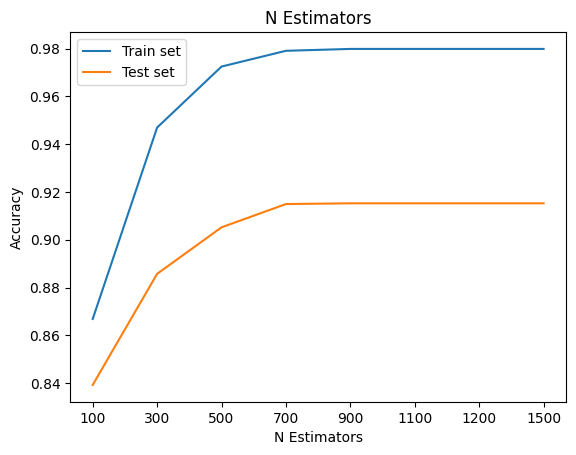

In [14]:
accu_train = []
accu_test = []

for n_estimators in n_estimators_list:
  model = XGBClassifier(n_estimators = n_estimators, learning_rate = 0.1, verbosity = 1, random_state = seed)
  model.fit(X_train_fit, y_train_fit, eval_set = [(X_train_eval, y_train_eval)], early_stopping_rounds = 10)
  model.best_iteration

  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)
  train_accuracy = accuracy_score(y_train_pred, y_train)
  test_accuracy = accuracy_score(y_test_pred, y_test)
  accu_train.append(train_accuracy)
  accu_test.append(test_accuracy)

plt.title("N Estimators")
plt.ylabel("Accuracy")
plt.xlabel("N Estimators")
plt.xticks(ticks = range(len(n_estimators_list)), labels = n_estimators_list)
plt.plot(accu_train)
plt.plot(accu_test)
plt.legend(["Train set","Test set"])
plt.show()

We set `n_estimators = 700`

[0]	validation_0-logloss:0.69107
[1]	validation_0-logloss:0.68892
[2]	validation_0-logloss:0.68679
[3]	validation_0-logloss:0.68469
[4]	validation_0-logloss:0.68262
[5]	validation_0-logloss:0.68057
[6]	validation_0-logloss:0.67852
[7]	validation_0-logloss:0.67652
[8]	validation_0-logloss:0.67455
[9]	validation_0-logloss:0.67257
[10]	validation_0-logloss:0.67061
[11]	validation_0-logloss:0.66870
[12]	validation_0-logloss:0.66678
[13]	validation_0-logloss:0.66492
[14]	validation_0-logloss:0.66304
[15]	validation_0-logloss:0.66123
[16]	validation_0-logloss:0.65940
[17]	validation_0-logloss:0.65762
[18]	validation_0-logloss:0.65582
[19]	validation_0-logloss:0.65407
[20]	validation_0-logloss:0.65236
[21]	validation_0-logloss:0.65060
[22]	validation_0-logloss:0.64891


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[23]	validation_0-logloss:0.64721
[24]	validation_0-logloss:0.64554
[25]	validation_0-logloss:0.64387
[26]	validation_0-logloss:0.64224
[27]	validation_0-logloss:0.64060
[28]	validation_0-logloss:0.63897
[29]	validation_0-logloss:0.63736
[30]	validation_0-logloss:0.63575
[31]	validation_0-logloss:0.63414
[32]	validation_0-logloss:0.63255
[33]	validation_0-logloss:0.63098
[34]	validation_0-logloss:0.62944
[35]	validation_0-logloss:0.62790
[36]	validation_0-logloss:0.62644
[37]	validation_0-logloss:0.62493
[38]	validation_0-logloss:0.62346
[39]	validation_0-logloss:0.62201
[40]	validation_0-logloss:0.62058
[41]	validation_0-logloss:0.61914
[42]	validation_0-logloss:0.61770
[43]	validation_0-logloss:0.61631
[44]	validation_0-logloss:0.61493
[45]	validation_0-logloss:0.61356
[46]	validation_0-logloss:0.61221
[47]	validation_0-logloss:0.61089
[48]	validation_0-logloss:0.60955
[49]	validation_0-logloss:0.60823
[50]	validation_0-logloss:0.60694
[51]	validation_0-logloss:0.60565
[52]	validatio

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-logloss:0.62684
[22]	validation_0-logloss:0.62438
[23]	validation_0-logloss:0.62194
[24]	validation_0-logloss:0.61954
[25]	validation_0-logloss:0.61719
[26]	validation_0-logloss:0.61487
[27]	validation_0-logloss:0.61261
[28]	validation_0-logloss:0.61040
[29]	validation_0-logloss:0.60819
[30]	validation_0-logloss:0.60598
[31]	validation_0-logloss:0.60379
[32]	validation_0-logloss:0.60172
[33]	validation_0-logloss:0.59962
[34]	validation_0-logloss:0.59761
[35]	validation_0-logloss:0.59563
[36]	validation_0-logloss:0.59366
[37]	validation_0-logloss:0.59175
[38]	validation_0-logloss:0.58986
[39]	validation_0-logloss:0.58795
[40]	validation_0-logloss:0.58612
[41]	validation_0-logloss:0.58429
[42]	validation_0-logloss:0.58255
[43]	validation_0-logloss:0.58080
[44]	validation_0-logloss:0.57906
[45]	validation_0-logloss:0.57743
[46]	validation_0-logloss:0.57576
[47]	validation_0-logloss:0.57413
[48]	validation_0-logloss:0.57251
[49]	validation_0-logloss:0.57091
[50]	validatio

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-logloss:0.57858
[15]	validation_0-logloss:0.57341
[16]	validation_0-logloss:0.56878
[17]	validation_0-logloss:0.56433
[18]	validation_0-logloss:0.55987
[19]	validation_0-logloss:0.55587
[20]	validation_0-logloss:0.55202
[21]	validation_0-logloss:0.54798
[22]	validation_0-logloss:0.54434
[23]	validation_0-logloss:0.54090
[24]	validation_0-logloss:0.53752
[25]	validation_0-logloss:0.53449
[26]	validation_0-logloss:0.53149
[27]	validation_0-logloss:0.52864
[28]	validation_0-logloss:0.52570
[29]	validation_0-logloss:0.52224
[30]	validation_0-logloss:0.51967
[31]	validation_0-logloss:0.51642
[32]	validation_0-logloss:0.51396
[33]	validation_0-logloss:0.51175
[34]	validation_0-logloss:0.50953
[35]	validation_0-logloss:0.50718
[36]	validation_0-logloss:0.50510
[37]	validation_0-logloss:0.50301
[38]	validation_0-logloss:0.50112
[39]	validation_0-logloss:0.49855
[40]	validation_0-logloss:0.49668
[41]	validation_0-logloss:0.49446
[42]	validation_0-logloss:0.49282
[43]	validatio

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-logloss:0.52132
[9]	validation_0-logloss:0.51166
[10]	validation_0-logloss:0.50391
[11]	validation_0-logloss:0.49731
[12]	validation_0-logloss:0.49067
[13]	validation_0-logloss:0.48512
[14]	validation_0-logloss:0.47881
[15]	validation_0-logloss:0.47491
[16]	validation_0-logloss:0.47002
[17]	validation_0-logloss:0.46598
[18]	validation_0-logloss:0.46258
[19]	validation_0-logloss:0.45910
[20]	validation_0-logloss:0.45524
[21]	validation_0-logloss:0.45277
[22]	validation_0-logloss:0.45032
[23]	validation_0-logloss:0.44854
[24]	validation_0-logloss:0.44552
[25]	validation_0-logloss:0.44373
[26]	validation_0-logloss:0.44056
[27]	validation_0-logloss:0.43801
[28]	validation_0-logloss:0.43581
[29]	validation_0-logloss:0.43432
[30]	validation_0-logloss:0.43207
[31]	validation_0-logloss:0.43136
[32]	validation_0-logloss:0.43047
[33]	validation_0-logloss:0.42816
[34]	validation_0-logloss:0.42741
[35]	validation_0-logloss:0.42617
[36]	validation_0-logloss:0.42360
[37]	validation_

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-logloss:0.40516
[19]	validation_0-logloss:0.40421
[20]	validation_0-logloss:0.40290
[21]	validation_0-logloss:0.39984
[22]	validation_0-logloss:0.39628
[23]	validation_0-logloss:0.39612
[24]	validation_0-logloss:0.39490
[25]	validation_0-logloss:0.39404
[26]	validation_0-logloss:0.39146
[27]	validation_0-logloss:0.38886
[28]	validation_0-logloss:0.38687
[29]	validation_0-logloss:0.38441
[30]	validation_0-logloss:0.38191
[31]	validation_0-logloss:0.37966
[32]	validation_0-logloss:0.37673
[33]	validation_0-logloss:0.37385
[34]	validation_0-logloss:0.37315
[35]	validation_0-logloss:0.37208
[36]	validation_0-logloss:0.36877
[37]	validation_0-logloss:0.36630
[38]	validation_0-logloss:0.36432
[39]	validation_0-logloss:0.36186
[40]	validation_0-logloss:0.36129
[41]	validation_0-logloss:0.36044
[42]	validation_0-logloss:0.35799
[43]	validation_0-logloss:0.35656
[44]	validation_0-logloss:0.35584
[45]	validation_0-logloss:0.35485
[46]	validation_0-logloss:0.35224
[47]	validatio

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.38407
[18]	validation_0-logloss:0.37715
[19]	validation_0-logloss:0.37195
[20]	validation_0-logloss:0.36944
[21]	validation_0-logloss:0.36864
[22]	validation_0-logloss:0.36573
[23]	validation_0-logloss:0.36185
[24]	validation_0-logloss:0.35648
[25]	validation_0-logloss:0.35280
[26]	validation_0-logloss:0.35112
[27]	validation_0-logloss:0.34791
[28]	validation_0-logloss:0.34768
[29]	validation_0-logloss:0.34152
[30]	validation_0-logloss:0.33595
[31]	validation_0-logloss:0.33526
[32]	validation_0-logloss:0.33535
[33]	validation_0-logloss:0.33156
[34]	validation_0-logloss:0.32983
[35]	validation_0-logloss:0.32903
[36]	validation_0-logloss:0.32500
[37]	validation_0-logloss:0.32311
[38]	validation_0-logloss:0.32290
[39]	validation_0-logloss:0.32203
[40]	validation_0-logloss:0.32140
[41]	validation_0-logloss:0.32013
[42]	validation_0-logloss:0.31637
[43]	validation_0-logloss:0.31073
[44]	validation_0-logloss:0.31024
[45]	validation_0-logloss:0.30848
[46]	validatio

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-logloss:0.41399
[11]	validation_0-logloss:0.40755
[12]	validation_0-logloss:0.40706
[13]	validation_0-logloss:0.40177
[14]	validation_0-logloss:0.39714
[15]	validation_0-logloss:0.39631
[16]	validation_0-logloss:0.38763
[17]	validation_0-logloss:0.38340
[18]	validation_0-logloss:0.37752
[19]	validation_0-logloss:0.37539
[20]	validation_0-logloss:0.37492
[21]	validation_0-logloss:0.37203
[22]	validation_0-logloss:0.36338
[23]	validation_0-logloss:0.35385
[24]	validation_0-logloss:0.34506
[25]	validation_0-logloss:0.34222
[26]	validation_0-logloss:0.33728
[27]	validation_0-logloss:0.33368
[28]	validation_0-logloss:0.32784
[29]	validation_0-logloss:0.32417
[30]	validation_0-logloss:0.32141
[31]	validation_0-logloss:0.31275
[32]	validation_0-logloss:0.31066
[33]	validation_0-logloss:0.30910
[34]	validation_0-logloss:0.30801
[35]	validation_0-logloss:0.30478
[36]	validation_0-logloss:0.30181
[37]	validation_0-logloss:0.30101
[38]	validation_0-logloss:0.29946
[39]	validatio

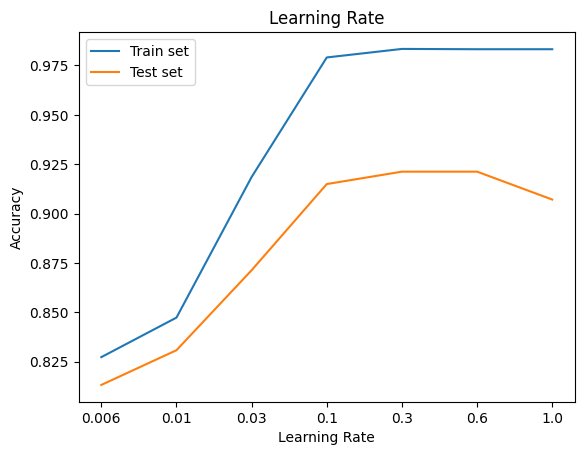

In [15]:
accu_train = []
accu_test = []

for learning_rate in learning_rate_list:
  model = XGBClassifier(n_estimators = 700, learning_rate = learning_rate, verbosity = 1, random_state = seed)
  model.fit(X_train_fit, y_train_fit, eval_set = [(X_train_eval, y_train_eval)], early_stopping_rounds = 10)
  model.best_iteration

  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)
  train_accuracy = accuracy_score(y_train_pred, y_train)
  test_accuracy = accuracy_score(y_test_pred, y_test)
  accu_train.append(train_accuracy)
  accu_test.append(test_accuracy)

plt.title("Learning Rate")
plt.ylabel("Accuracy")
plt.xlabel("Learning Rate")
plt.xticks(ticks = range(len(learning_rate_list)), labels = learning_rate_list)
plt.plot(accu_train)
plt.plot(accu_test)
plt.legend(["Train set","Test set"])
plt.show()

We set `learning_rate = 0.6`

##Implementing the model and checking the accuracy

In [16]:
model = XGBClassifier(n_estimators = 700, learning_rate = 0.6, verbosity = 1, random_state = seed)
model.fit(X_train_fit, y_train_fit, eval_set = [(X_train_eval, y_train_eval)], early_stopping_rounds = 10)

[0]	validation_0-logloss:0.53915
[1]	validation_0-logloss:0.48856
[2]	validation_0-logloss:0.46140
[3]	validation_0-logloss:0.44806
[4]	validation_0-logloss:0.44261
[5]	validation_0-logloss:0.42973
[6]	validation_0-logloss:0.42293
[7]	validation_0-logloss:0.42117


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-logloss:0.41366
[9]	validation_0-logloss:0.40388
[10]	validation_0-logloss:0.40072
[11]	validation_0-logloss:0.39618
[12]	validation_0-logloss:0.39572
[13]	validation_0-logloss:0.39344
[14]	validation_0-logloss:0.39159
[15]	validation_0-logloss:0.38671
[16]	validation_0-logloss:0.38617
[17]	validation_0-logloss:0.38407
[18]	validation_0-logloss:0.37715
[19]	validation_0-logloss:0.37195
[20]	validation_0-logloss:0.36944
[21]	validation_0-logloss:0.36864
[22]	validation_0-logloss:0.36573
[23]	validation_0-logloss:0.36185
[24]	validation_0-logloss:0.35648
[25]	validation_0-logloss:0.35280
[26]	validation_0-logloss:0.35112
[27]	validation_0-logloss:0.34791
[28]	validation_0-logloss:0.34768
[29]	validation_0-logloss:0.34152
[30]	validation_0-logloss:0.33595
[31]	validation_0-logloss:0.33526
[32]	validation_0-logloss:0.33535
[33]	validation_0-logloss:0.33156
[34]	validation_0-logloss:0.32983
[35]	validation_0-logloss:0.32903
[36]	validation_0-logloss:0.32500
[37]	validation_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.6, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=700, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [17]:
model.best_iteration

157

Best accuracy is achieved at iteration 157

In [18]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [19]:
print(f"Train Accuracy: {accuracy_score(y_train_pred, y_train)}\nTest Accuracy: {accuracy_score(y_test_pred, y_test)}")

Train Accuracy: 0.9832025117739404
Test Accuracy: 0.921217827997489


Final accuracy of test set is approximately 0.921